In [32]:
import pandas as pd
import geopandas as gpd
import numpy as np
import pyproj
from shapely.geometry import Point
from shapely.ops import transform
from typing import Optional
from tqdm import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import sys
import os

sys.path.append('scripts')

## Create Subsegmen Points

In [3]:
from points_cloning import generate_artificial_points

In [6]:
gdf_points = pd.read_csv('../raw/segmen_ksa_selindo.csv')
df_points = generate_artificial_points(gdf_points, ['idsegmen','strati'], 1, 100)
index_mapping = {1: 'A1', 2: 'A2', 3: 'A3', 4: 'B1', 5: 'B2', 6: 'B3', 7: 'C1', 8: 'C2', 9: 'C3'}

df_points['idsubsegmen'] = df_points['index'].map(index_mapping)
df_points.to_csv('generated_points.csv', index=False)
df_points.head()

Processing initial points: 100%|██████████| 25576/25576 [07:20<00:00, 58.12it/s]


,iterx,itery,lat,long,index,idsegmen,strati,idsubsegmen
0,1,1,2.380977,96.481474,1,110101001,S2,A1
1,1,2,2.380079,96.481474,2,110101001,S2,A2
2,1,3,2.379182,96.481474,3,110101001,S2,A3
3,2,1,2.380977,96.482372,4,110101001,S2,B1
4,2,2,2.380079,96.482372,5,110101001,S2,B2


In [4]:
df_points = pd.read_csv('generated_points.csv')
geometry = [Point(xy) for xy in zip(df_points['long'], df_points['lat'])]
df_points = gpd.GeoDataFrame(df_points, geometry=geometry)

df_points.set_crs(epsg=4326, inplace=True).head()

,iterx,itery,lat,long,index,idsegmen,strati,idsubsegmen,geometry
0,1,1,2.380977,96.481474,1,110101001,S2,A1,POINT (96.48147 2.38098)
1,1,2,2.380079,96.481474,2,110101001,S2,A2,POINT (96.48147 2.38008)
2,1,3,2.379182,96.481474,3,110101001,S2,A3,POINT (96.48147 2.37918)
3,2,1,2.380977,96.482372,4,110101001,S2,B1,POINT (96.48237 2.38098)
4,2,2,2.380079,96.482372,5,110101001,S2,B2,POINT (96.48237 2.38008)


## Indexing MGRS Each Subsegmen

In [5]:
mgrs = gpd.read_file('../shared_ksa/00_Data_Input/indo_mgrs_grid_100km.gpkg')
mgrs.head()

,EASTING,NORTHING,100kmSQ_ID,GZD,MGRS,geometry
0,100000mE,800000mN,AP,46N,46NAP,"MULTIPOLYGON (((90.27865 8, 90.28351 7.22937, ..."
1,200000mE,800000mN,BP,46N,46NBP,"MULTIPOLYGON (((91.1854 8, 91.18862 7.23386, 9..."
2,300000mE,800000mN,CP,46N,46NCP,"MULTIPOLYGON (((92.09259 8, 92.09419 7.23656, ..."
3,400000mE,800000mN,DP,46N,46NDP,"MULTIPOLYGON (((93 8, 93 7.23747, 92.09419 7.2..."
4,500000mE,800000mN,EP,46N,46NEP,"MULTIPOLYGON (((93.90581 7.23656, 93 7.23747, ..."


In [6]:
intersected_gdf = gpd.overlay(df_points, mgrs, how='intersection')
intersected_gdf = intersected_gdf.drop_duplicates(subset='geometry')
intersected_gdf = intersected_gdf.drop(columns = ['iterx', 'itery', 'index'])
intersected_gdf.head()

,lat,long,idsegmen,strati,idsubsegmen,EASTING,NORTHING,100kmSQ_ID,GZD,MGRS,geometry
0,2.380977,96.481474,110101001,S2,A1,200000mE,200000mN,KC,47N,47NKC,POINT (96.48147 2.38098)
1,2.380079,96.481474,110101001,S2,A2,200000mE,200000mN,KC,47N,47NKC,POINT (96.48147 2.38008)
2,2.379182,96.481474,110101001,S2,A3,200000mE,200000mN,KC,47N,47NKC,POINT (96.48147 2.37918)
3,2.380977,96.482372,110101001,S2,B1,200000mE,200000mN,KC,47N,47NKC,POINT (96.48237 2.38098)
4,2.380079,96.482372,110101001,S2,B2,200000mE,200000mN,KC,47N,47NKC,POINT (96.48237 2.38008)


## Data Cloning

In [7]:
intersected_gdf.rename(columns={'lat': 'y', 'long': 'x'}, inplace=True)

In [9]:
def process_chunk(chunk):
    return generate_artificial_points(chunk, ['idsegmen','strati','idsubsegmen','EASTING','NORTHING','100kmSQ_ID','GZD','MGRS'], 2, 20)

def chunkify(df, n):
    return np.array_split(df, n)

In [ ]:
n_chunks = 500
chunks = chunkify(intersected_gdf, n_chunks)

if __name__ == '__main__':
    with mp.Pool(mp.cpu_count()) as pool:
        results = pool.map(process_chunk, chunks)

    # Combine results
    cloned_points = pd.concat(results)
    cloned_points.to_csv('cloned_points.csv', index=False)
    print(cloned_points.head())

Processing initial points:   0%|          | 0/460 [00:00<?, ?it/s]26.16it/s]

Processing initial points: 100%|██████████| 460/460 [00:17<00:00, 25.92it/s]

Processing initial points: 100%|█████████▉| 459/460 [00:18<00:00, 17.44it/s]

Processing initial points:  83%|████████▎ | 381/460 [00:22<00:06, 13.00it/s]

Processing initial points:  98%|█████████▊| 452/460 [00:25<00:00, 20.92it/s]

Processing initial points: 100%|██████████| 460/460 [00:26<00:00, 17.49it/s]

Processing initial points:  15%|█▌        | 70/459 [00:03<00:16, 23.07it/s]]

Processing initial points:  18%|█▊        | 82/460 [00:04<00:24, 15.31it/s]]

Processing initial points:  17%|█▋        | 76/459 [00:04<00:21, 17.57it/s]]

Processing initial points:  10%|▉         | 45/459 [00:02<00:21, 19.49it/s]]

Processing initial points:  39%|███▉      | 180/459 [00:09<00:13, 21.35it/s]

In [14]:
cloned_points.head()

,iterx,itery,lat,long,index,idsegmen,strati,idsubsegmen,EASTING,NORTHING,100kmSQ_ID,GZD,MGRS
0,1,1,2.381336,96.481115,1,110101001,S2,A1,200000mE,200000mN,KC,47N,47NKC
1,1,2,2.381156,96.481115,2,110101001,S2,A1,200000mE,200000mN,KC,47N,47NKC
2,1,3,2.380977,96.481115,3,110101001,S2,A1,200000mE,200000mN,KC,47N,47NKC
3,1,4,2.380797,96.481115,4,110101001,S2,A1,200000mE,200000mN,KC,47N,47NKC
4,1,5,2.380618,96.481115,5,110101001,S2,A1,200000mE,200000mN,KC,47N,47NKC


## KSA long, Decode, and Filter

In [28]:
ksa = pd.read_csv('../raw/ksa.csv', delimiter=';')

ksa_melted = ksa.drop(columns=['Strata','Latitude','Longitude']).melt(id_vars=['idsegmen', 'idsubsegmen'], var_name='year_month', value_name='obs')
ksa_melted[['bulan', 'tahun']] = ksa_melted['year_month'].str.split('-', expand=True)
data_ksa= ksa_melted[['idsegmen', 'idsubsegmen', 'tahun', 'bulan', 'obs']]

month_map = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
    'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
    'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

data_ksa['bulan'] = data_ksa['bulan'].map(month_map)
data_ksa['tahun'] = data_ksa.tahun.astype(int)

data_ksa.head()

,idsegmen,idsubsegmen,tahun,bulan,obs
0,110101001,A1,22,1,8.0
1,110101001,A2,22,1,4.0
2,110101001,A3,22,1,4.0
3,110101001,B1,22,1,8.0
4,110101001,B2,22,1,4.0


In [29]:
years = [22, 23]
months = list(range(1, 13))

tmpt = [(year, month) for year in years for month in months]
tmpt = pd.DataFrame(tmpt, columns=['tahun', 'bulan'])
tmpt['nth'] = tmpt.index
data_ksa = data_ksa.merge(tmpt, on=['tahun', 'bulan'], how='left')
data_ksa['id_x'] = data_ksa['idsegmen'].astype(str)+data_ksa['idsubsegmen']


data_ksa['obs'] = np.floor(data_ksa['obs'])
data_ksa['class'] = None
data_ksa.head()

,idsegmen,idsubsegmen,tahun,bulan,obs,nth,id_x,class
0,110101001,A1,22,1,8.0,0,110101001A1,None
1,110101001,A2,22,1,4.0,0,110101001A2,None
2,110101001,A3,22,1,4.0,0,110101001A3,None
3,110101001,B1,22,1,8.0,0,110101001B1,None
4,110101001,B2,22,1,4.0,0,110101001B2,None


In [30]:
from ksa_decoding import parallel_relabeling

result = parallel_relabeling(data_ksa, id_col='id_x', nth_col='nth', obs_col='obs', batch_size=1000)
result.to_csv('relabelled_data_ksa.csv', index=False)

In [38]:
result['idprov'] = result['idsegmen'].astype(str).str[:2]

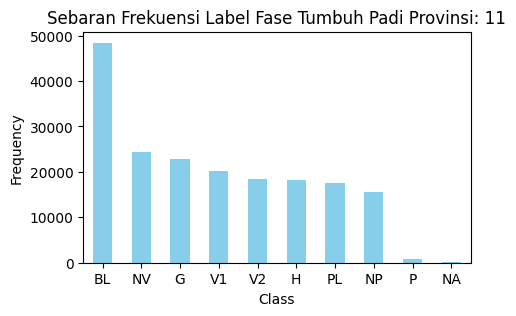

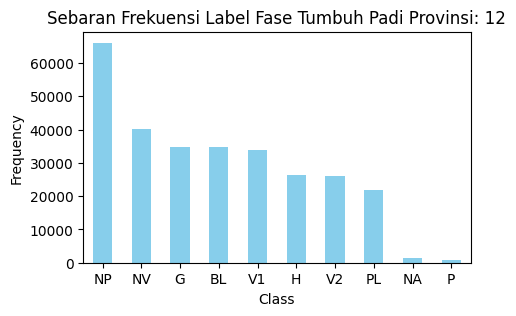

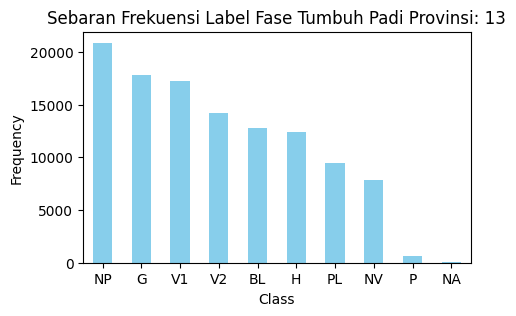

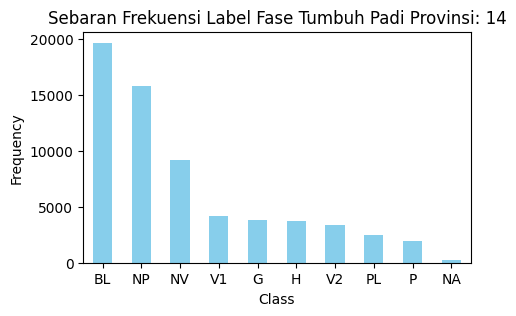

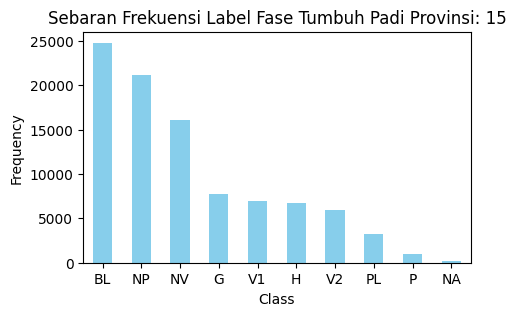

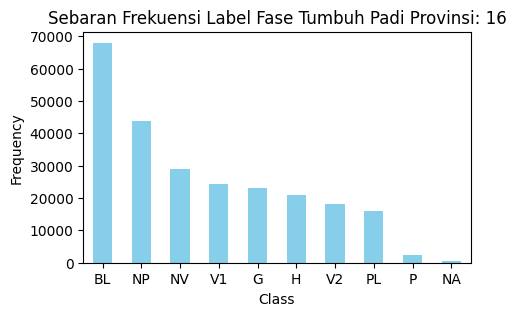

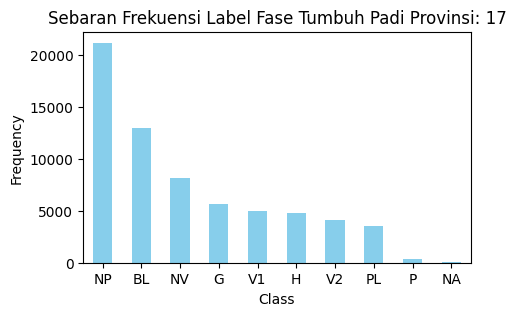

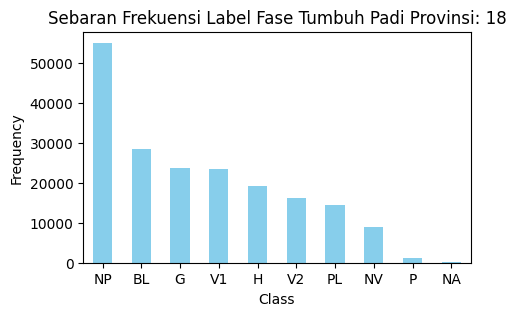

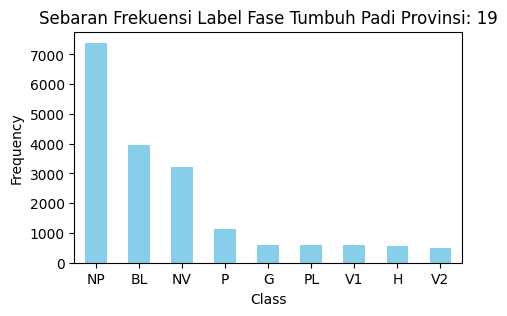

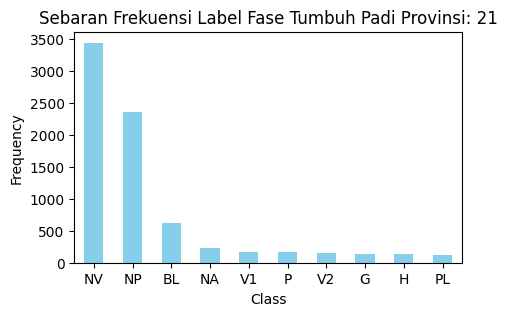

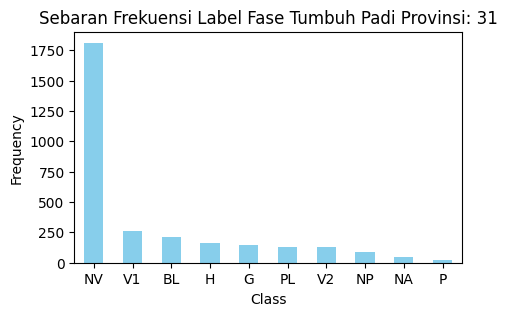

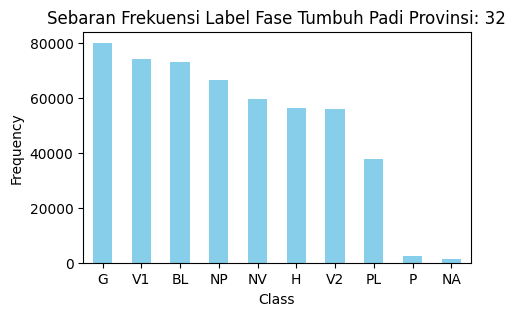

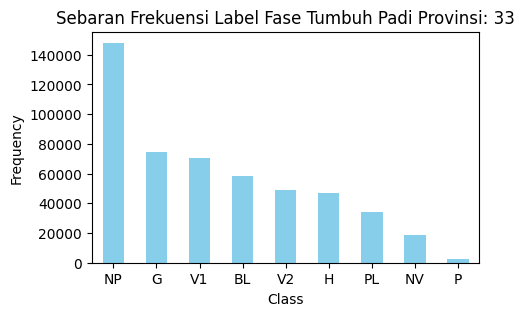

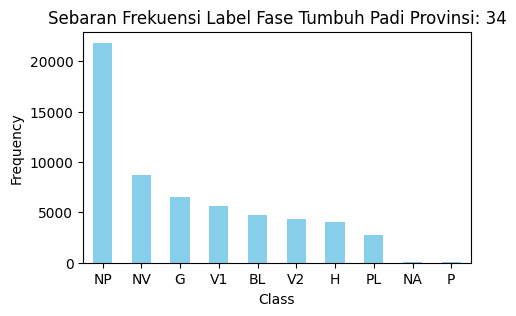

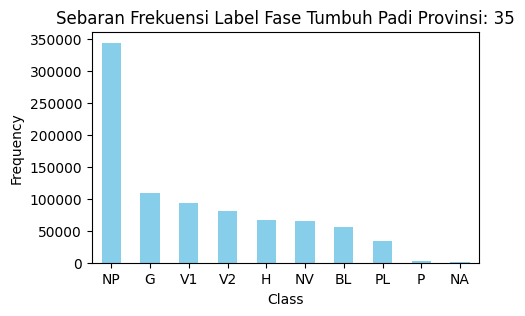

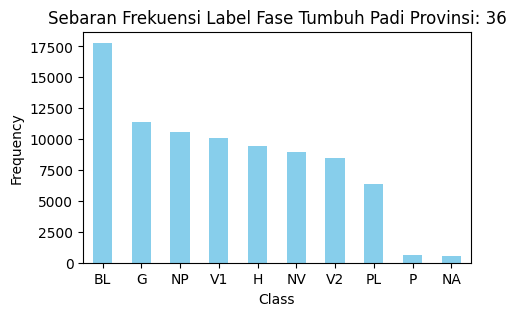

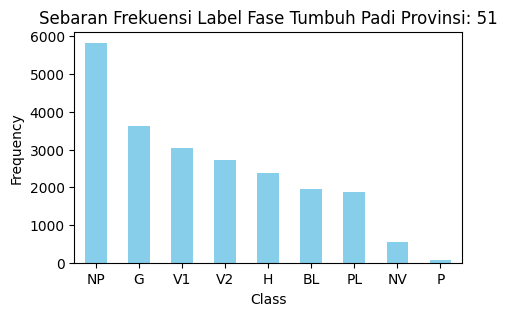

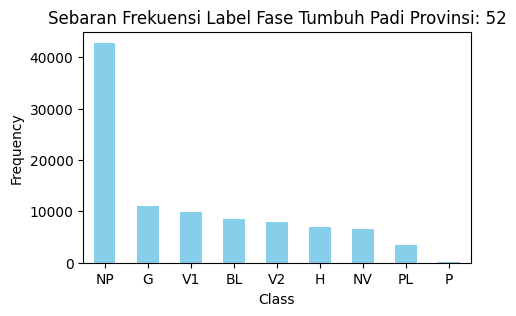

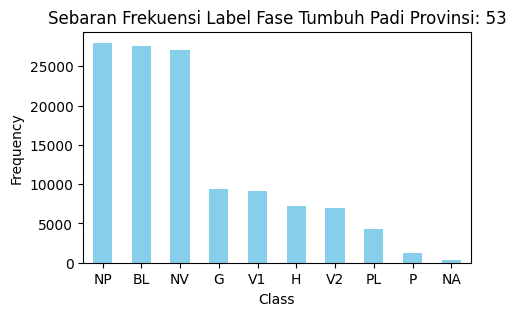

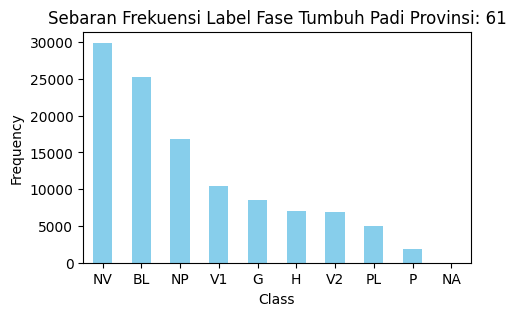

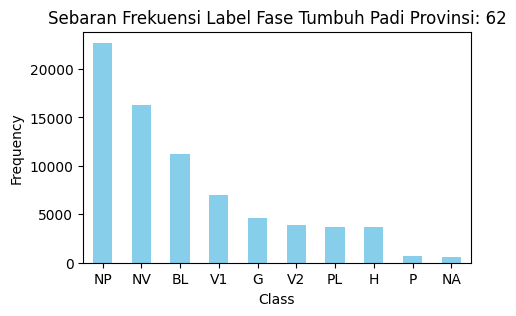

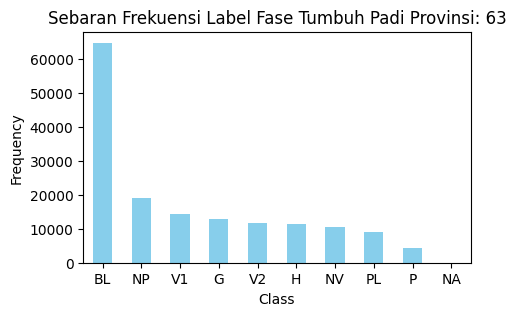

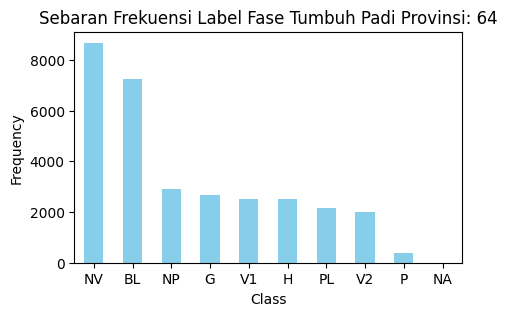

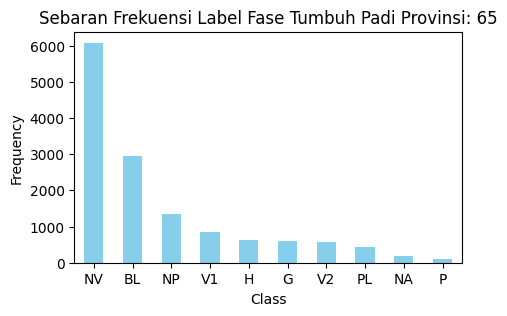

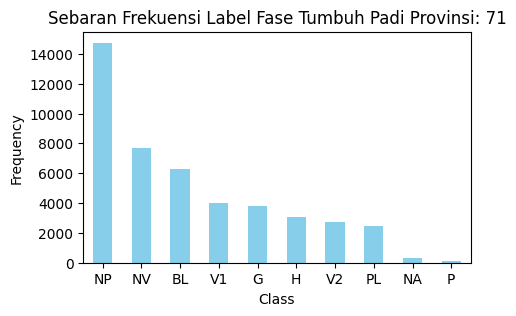

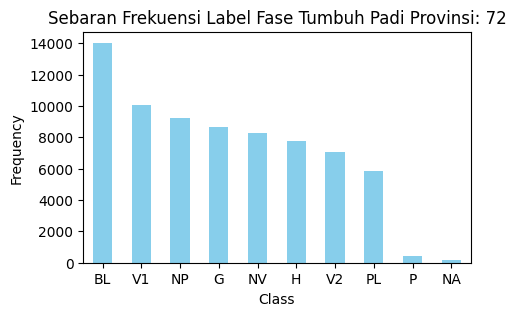

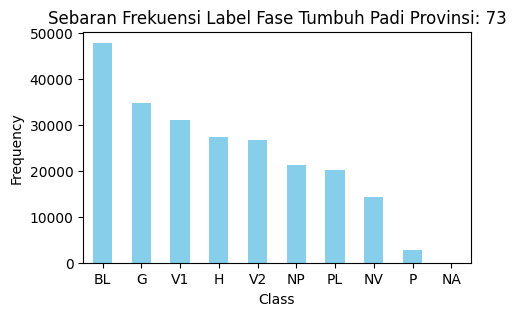

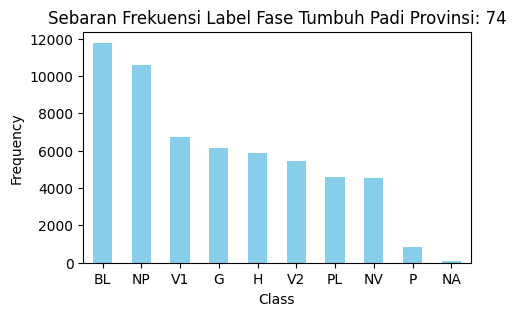

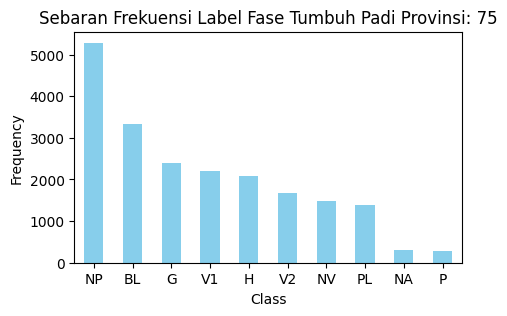

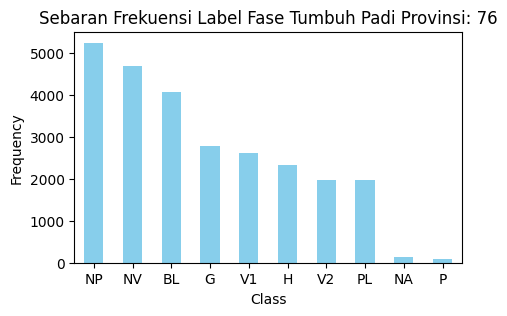

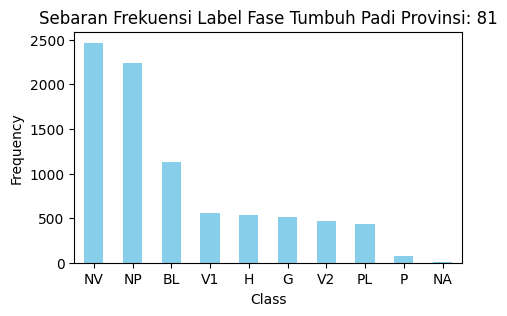

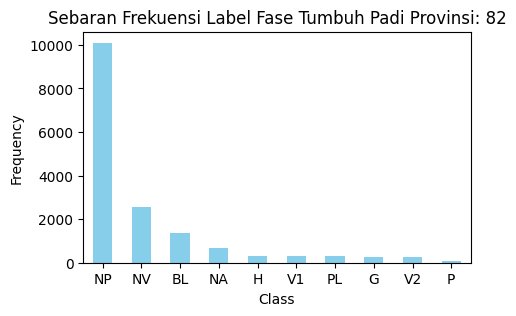

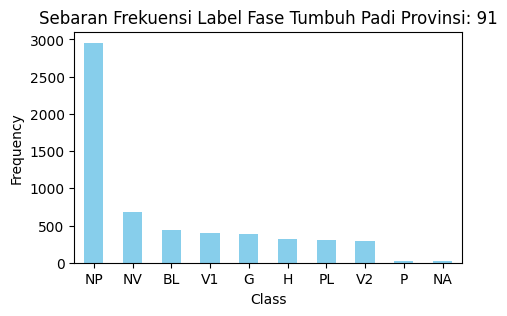

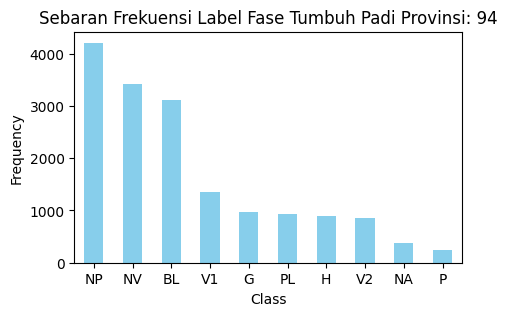

In [43]:
unique_provinces = result['idprov'].unique()

for province in unique_provinces:
    province_data = result[result['idprov'] == province]
    class_counts = province_data['class'].value_counts()
    
    plt.figure(figsize=(5, 3))
    class_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Sebaran Frekuensi Label Fase Tumbuh Padi Provinsi: {province}')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(rotation=0)
    plt.show()

In [ ]:
data_ksa